# Figures for Mapping GHG emissions paper

In [1]:
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

colors = ['#fc8d59', '#4575b4',  '#d73027', '#91bfdb', '#191922', '#d3d3d3']

def filter_df(df, cols, filters):
    for col, filt in zip(cols, filters):
        df = df[[i in filt for i in df[col]]]
    return df

output_path = '/figures/'

In [2]:
# Load data
path = '/data/'
data = pd.read_parquet(path+'combined/240325_All/facilityEmissions_all.parquet')

In [3]:
years = [str(i) for i in range(1978, 2051)]
years_sigma = [year+'_sigma' for year in years]
data_filt = data[['Product type', 'Product group', 'Gas', 'Region', 'COUNTRY/TERRITORY', 'Type']+years+ years_sigma]
data_filt = data_filt.groupby(['Product type', 'Product group', 'Gas', 'Region', 'COUNTRY/TERRITORY', 'Type']).sum().reset_index()

data_filt['Product group'] = data_filt['Product group'].replace({'Thermosets, fibre & elastomers':'Thermosets, fibres\n& elastomers', 'Solvents, additives & explosives': 'Solvents, additives\n& explosives'})
data_filt['Type'] = data_filt['Type'].replace({'Direct Utilities':'Direct Energy Use', 'Indirect Utilities': 'Indirect Energy Use'})

data_with_elec = data_filt[[i not in ['EI & CM', 'IHS CtOG'] for i in data_filt['Type']]]
data_filt = data_filt[[i not in ['EI & CM', 'Electricity', 'IHS CtOG'] for i in data_filt['Type']]]

year_used = '2020'
counting_types = ['Direct Process', 'Indirect Energy Use', 'Direct Energy Use', 'Feedstock']
scale_factor = 1E3

In [4]:
data_path = '/data/'
impactMethods_20 = data_path+ "extra_inputs/EI_3_8_IPCC2013_GWP20a.xml"
impactMethods_100 = data_path+ "extra_inputs/EI_3_8_IPCC2013_GWP100a.xml"

import xml.etree.ElementTree as ET
pd.options.mode.chained_assignment = None

# CO2e conversion of gases
# Define functions
def to_listlist(inlist: list):
    """Ensures element is a list of lists even if single inner list"""
    return [inlist] if type(inlist[0]) is not list else inlist

def read_xml_attributes(filepath:str,branches:list,attributes:list,df=False):
    """This function creates a dataframe of attributes within an xml file.\n
    Inputs:\n
    filepath - path to xml file\n
    branches - list of successive branch choices\n
    attributes - attributes to be read from chosen branch\n
    Outputs:\n
    df - pandas dataframe of attributes for each end branch\n
    Requirements: pandas as pd, xml.etree.ElementTree as ET"""
    if df is False: df = pd.DataFrame([],columns=[i for sublist in to_listlist(attributes) for i in sublist])
    tree_loc = ET.parse(filepath). getroot()
    branches, attributes = to_listlist(branches), to_listlist(attributes)
    attr_values = dict()
    for pathnum, path in enumerate(branches):
        for branch in path:
            for num,val in enumerate([branch in i.tag for i in tree_loc]):
                if val:
                    if branch is path[-1]:
                        attr_values.update(dict(zip(attributes[pathnum],[tree_loc[num].attrib[i] if i else tree_loc[num].text for i in attributes[pathnum]])))
                        if path is branches[-1]:
                            df = pd.concat([df, pd.DataFrame(np.array([[i] for i in attr_values.values()]).transpose(),columns=attr_values.keys())],ignore_index=True)
                    else:
                        tree_loc=tree_loc[num]
                        break
    return df

impacts_20, impacts_100 = [read_xml_attributes(input_file,['dataset','flowData','exchange'],['name','category','subCategory','meanValue']).rename(columns={'meanValue':name}) for input_file, name in zip([impactMethods_20, impactMethods_100], ['CO2e_20a', 'CO2e_100a'])]
impacts = impacts_20.merge(impacts_100, on=['name', 'category', 'subCategory'], how='outer')

impacts = impacts.groupby('name').first().reset_index()

In [5]:
plot_name = 'Gas'
data_used = filter_df(data_filt, ['Type'],[counting_types]).groupby([plot_name]).sum().reset_index()[[plot_name, year_used, year_used+'_sigma']].sort_values(year_used, ascending=False)
data_used[year_used], data_used[year_used+'_sigma'] = data_used[year_used]/scale_factor, data_used[year_used+'_sigma']/scale_factor
data_used['Gas'] = data_used['Gas'].replace({'Dinitrogen monoxide':'Nitric oxide', 'Nitric oxide':'Dinitrogen monoxide'})

ipcc_gas_names = {'Carbon dioxide':'Carbon dioxide, fossil',
 'Carbon monoxide':'Carbon monoxide, fossil',
 'Ethane':'Ethane, 1,1-difluoro-, HFC-152a',
 'Methane':'Methane, fossil',
 'Other':'Carbon dioxide, fossil'}

gas_summ = data_used.merge(impacts, left_on=data_used['Gas'].replace(ipcc_gas_names), right_on='name', how='left')
gas_summ_20 = gas_summ.dropna()
gas_summ_20[year_used] = gas_summ_20[year_used]*gas_summ_20['CO2e_20a'].astype(float)
gas_summ_20[year_used+'_sigma'] = gas_summ_20[year_used+'_sigma']*gas_summ_20['CO2e_20a'].astype(float)
gas_summ_20['Time horizon'] = '20-year'
gas_summ_20 = gas_summ_20.sort_values(year_used)
gas_summ_100 = gas_summ.dropna()
gas_summ_100[year_used] = gas_summ_100[year_used]*gas_summ_100['CO2e_100a'].astype(float)
gas_summ_100[year_used+'_sigma'] = gas_summ_100[year_used+'_sigma']*gas_summ_100['CO2e_100a'].astype(float)
gas_summ_100['Time horizon'] = '100-year'
gas_summ_100 = gas_summ_100.sort_values(year_used)
gas_summ = pd.concat((gas_summ_20, gas_summ_100))
gas_summ.sort_values(year_used, ascending=False, inplace=True)

total_2020_values = gas_summ.groupby('Gas')['2020'].sum().reset_index()
total_2020_values.rename(columns={'2020': 'Total_2020_Value'}, inplace=True)
gas_summ_sorted = pd.merge(gas_summ, total_2020_values, on='Gas')
gas_summ_sorted = gas_summ_sorted.sort_values(by=['Total_2020_Value', 'Time horizon'], ascending=[False, True])
gas_summ_sorted.reset_index(drop=True, inplace=True)

In [6]:
# Region plot
plot_name = 'COUNTRY/TERRITORY'
data_used = filter_df(data_filt, ['Gas', 'Type'],[['CO2e_100a'], counting_types]).groupby(['COUNTRY/TERRITORY']).sum().reset_index()[['COUNTRY/TERRITORY', '2020', '2020_sigma']].sort_values(year_used, ascending=False)
data_used[year_used], data_used[year_used+'_sigma'] = data_used[year_used]/scale_factor, data_used[year_used+'_sigma']/scale_factor

/var/folders/xm/c2mlyq6s23nb_g6_v4fylb7h0000gn/T/ipykernel_76710/3073068569.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data_used, x=year_used, y=plot_name, ax=axs[0],  alpha=alpha, palette=country_palette)
/var/folders/xm/c2mlyq6s23nb_g6_v4fylb7h0000gn/T/ipykernel_76710/3073068569.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data_used, x=year_used, y=plot_name, ax=axs[2],  alpha=alpha, palette=[colors[3], colors[2], colors[0], colors[1]]) #palette=[colors[3], colors[2], colors[0], colors[1]])


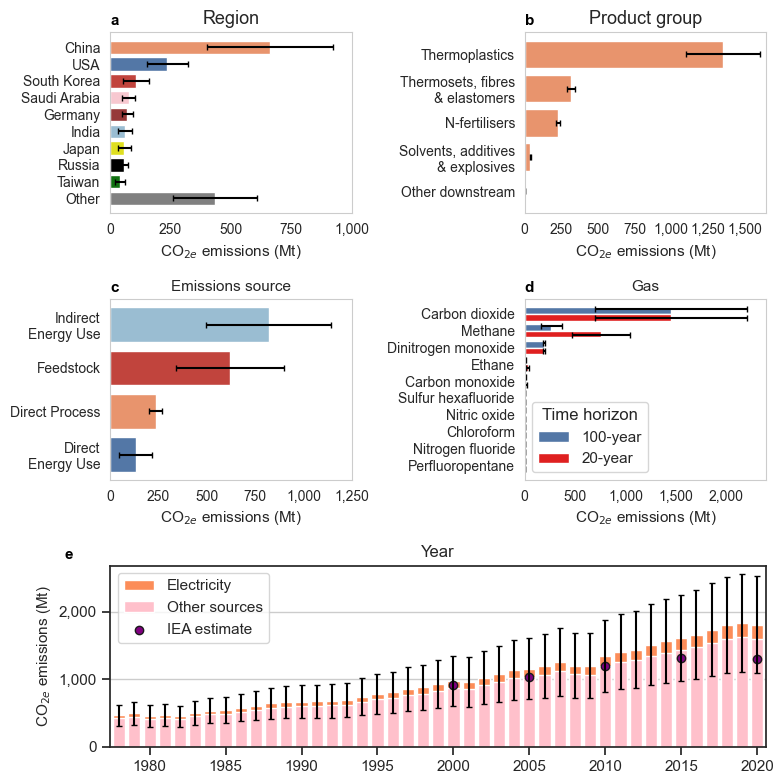

In [7]:
fig, axs = plt.subplots(3,2, figsize=[8,8], facecolor='white')
axs = axs.flatten()
fontsize = 11

plt.rcParams['font.size'] = 12
sns.set(font_scale=1)
sns.set_style('ticks')
alpha = 1
capsize = 2

# Country plot
plot_name = 'Region'
data_used = filter_df(data_filt, ['Gas', 'Type'],[['CO2e_100a'], counting_types]).groupby(['COUNTRY/TERRITORY']).sum().reset_index()[['COUNTRY/TERRITORY', '2020', '2020_sigma']].sort_values(year_used, ascending=False)
data_used[year_used], data_used[year_used+'_sigma'] = data_used[year_used]/scale_factor, data_used[year_used+'_sigma']/scale_factor

top_countries =  ['China','USA','South Korea','India','Russia','Saudi Arabia','Taiwan','Germany', 'Japan'] 
data_used = data_used.set_index('COUNTRY/TERRITORY')

other = pd.DataFrame(data_used[[i not in top_countries for i in data_used.index]].sum()).transpose()
other.index = ['Other']
other.index.name = 'COUNTRY/TERRITORY'
data_used = pd.concat((data_used.loc[top_countries].sort_values(by=year_used, ascending=False), other)).reset_index()
data_used.rename(columns={'COUNTRY/TERRITORY':'Region'}, inplace=True)

country_palette = colors[:3]+['pink', 'brown', colors[3], 'yellow', 'black', 'green', 'grey']
sns.barplot(data=data_used, x=year_used, y=plot_name, ax=axs[0],  alpha=alpha, palette=country_palette)
axs[0].errorbar(x=data_used[year_used], y=data_used['Region'].reset_index().index, xerr=data_used[year_used+'_sigma'], fmt='none', capsize=capsize, color='black' )
axs[0].set_ylabel(None)
axs[0].set_xlabel('CO$_{2e}$ emissions (Mt)', fontsize=fontsize)
axs[0].grid(axis='x')
axs[0].xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
axs[0].set_xlim([0, 1000])
axs[0].set_xticks([0,250,500,750,1000])
axs[0].set_title(plot_name, fontsize=fontsize+2)

# Product group
plot_name = 'Product group'
data_used = filter_df(data_filt, ['Gas', 'Product type'],[['CO2e_100a'], ['Downstream']]).groupby([plot_name]).sum().reset_index()[[plot_name, year_used, year_used+'_sigma']].sort_values(year_used, ascending=False)
data_used[year_used], data_used[year_used+'_sigma'] = data_used[year_used]/scale_factor, data_used[year_used+'_sigma']/scale_factor

sns.barplot(data=data_used, x=year_used, y=plot_name, ax=axs[1],  alpha=alpha, color=colors[0])
axs[1].errorbar(x=data_used[year_used], y=data_used[plot_name].reset_index().index, xerr=data_used[year_used+'_sigma'], fmt='none', capsize=capsize, color='black' )
axs[1].set_ylabel(None)
axs[1].set_xlabel('CO$_{2e}$ emissions (Mt)', fontsize=fontsize)
axs[1].grid(axis='x')
axs[1].xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
axs[1].set_xlim([0, 1650])
axs[1].set_xticks([0,250,500,750,1000,1250, 1500])
axs[1].set_title('Product group', fontsize=fontsize+2)

fig.tight_layout()

# Emissions source
plot_name = 'Type'
data_used = filter_df(data_filt, ['Gas',  'Type'],[['CO2e_100a'], counting_types]).groupby([plot_name]).sum().reset_index()[[plot_name, year_used, year_used+'_sigma']].sort_values(year_used, ascending=False)
data_used[year_used], data_used[year_used+'_sigma'] = data_used[year_used]/scale_factor, data_used[year_used+'_sigma']/scale_factor
data_used['Type'] = data_used['Type'].replace({'Direct Energy Use':'Direct\nEnergy Use', 'Indirect Energy Use': 'Indirect\nEnergy Use'})

sns.barplot(data=data_used, x=year_used, y=plot_name, ax=axs[2],  alpha=alpha, palette=[colors[3], colors[2], colors[0], colors[1]]) #palette=[colors[3], colors[2], colors[0], colors[1]])
axs[2].errorbar(x=data_used[year_used], y=data_used[plot_name].reset_index().index, xerr=data_used[year_used+'_sigma'], fmt='none', capsize=capsize, color='black' )
axs[2].set_ylabel(None)
axs[2].set_xlabel('CO$_{2e}$ emissions (Mt)', fontsize=fontsize)
axs[2].grid(axis='x')
axs[2].xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
axs[2].set_xlim([0, 1250])
axs[2].set_xticks([0,250,500,750,1000, 1250])
axs[2].set_title('Emissions source', fontsize=fontsize)

# Gases
plot_name = 'Gas'

bplot = sns.barplot(data=gas_summ.sort_values(year_used, ascending=False), x=year_used, y=plot_name, ax=axs[3],  alpha=alpha, color=colors[0], hue='Time horizon', palette=[colors[1], 'red'])
axs[3].errorbar(x=gas_summ_sorted[year_used], y=gas_summ_sorted[plot_name].reset_index().index*0.5-0.27, xerr=abs(gas_summ_sorted[year_used+'_sigma']), fmt='none', capsize=capsize, color='black' )
axs[3].set_ylabel(None)
axs[3].set_xlabel('CO$_{2e}$ emissions (Mt)', fontsize=fontsize)
axs[3].grid(axis='x')
axs[3].xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
axs[3].set_xlim([0, 2400])
axs[3].set_xticks([0,500,1000, 1500,  2000])
axs[3].set_title(plot_name, fontsize=fontsize)

# Emissions over time plot
gs = axs[4].get_gridspec()
axs[4].remove()
axs[5].remove()
axs[4] = fig.add_subplot(gs[2, :])

df1 = filter_df(data_filt, ['Gas', 'Type'], [['CO2e_100a'], counting_types]).sum()
hist_years = [str(i) for i in range(1978, 2021)]

axs[4].bar(range(1978, 2021), df1[hist_years]/scale_factor, color=colors[0], label='Electricity')

df_elec = filter_df(data_with_elec, ['Gas', 'Type'], [['CO2e_100a'], ['Electricity']]).sum()

df2 = df1.copy()
df2[hist_years] = df2[hist_years]-df_elec[hist_years]
axs[4].bar(range(1978, 2021), df2[hist_years]/scale_factor, color='pink', label='Other sources')

iea_x = [2000, 2005, 2010, 2015, 2020]#, 2021]
iea_y = np.array((0.91, 1.04,1.19, 1.32, 1.30))*1E3 #1.37

axs[4].scatter(iea_x, iea_y,  color='purple',edgecolor='k', label='IEA estimate')

axs[4].set_ylabel('CO$_{2e}$ emissions (Mt)', fontsize=fontsize)
axs[4].set_xlim(1977.4,2020.6)
axs[4].grid(axis='y')
handles, labels = axs[4].get_legend_handles_labels()
axs[4].legend(handles=[handles[1], handles[2], handles[0]], labels = [labels[1], labels[2], labels[0]], loc='upper left')
axs[4].yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

hist_sigmas = [str(i)+'_sigma' for i in range(1978, 2021)]
axs[4].errorbar(range(1978, 2021), df1[hist_years]/scale_factor, df1[hist_sigmas]/scale_factor, linestyle='None', color='black', capsize=capsize)
axs[4].set_title('Year')

fs = 11
h = 1.1
w = 0
axs[0].text(w, h, 'a', transform = axs[0].transAxes, fontsize=fs, fontweight = 'bold', color = 'black', va='top', ha='left', **{'fontname':'Arial'})
axs[1].text(w, h, 'b', transform = axs[1].transAxes, fontsize=fs, fontweight = 'bold', color = 'black', va='top', ha='left', **{'fontname':'Arial'})
axs[2].text(w, h, 'c', transform = axs[2].transAxes, fontsize=fs, fontweight = 'bold', color = 'black', va='top', ha='left', **{'fontname':'Arial'})
axs[3].text(w, h, 'd', transform = axs[3].transAxes, fontsize=fs, fontweight = 'bold', color = 'black', va='top', ha='left', **{'fontname':'Arial'})
axs[4].text(w-0.07, h, 'e', transform = axs[4].transAxes, fontsize=fs, fontweight = 'bold', color = 'black', va='top', ha='left', **{'fontname':'Arial'})

fig.tight_layout()

In [45]:
# Save output plot
fig.savefig(output_path+'Figure_1.eps', format='eps', bbox_inches='tight',dpi=300)

# Save output plot
fig.savefig(output_path+'Figure_1.png', format='png', bbox_inches='tight',dpi=300)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [8]:
year = '2020'
year_sigma = year+'_sigma'

ems_2020 = filter_df(data_filt, ['Gas', 'Type'], [['CO2e_100a'], counting_types]).sum()[[year, year_sigma]]
elec = filter_df(data_with_elec, ['Gas', 'Type'], [['CO2e_100a'], ['Electricity']]).sum()[[year, year_sigma]]
du_upstream = filter_df(data_filt, ['Gas', 'Type'], [['CO2e_100a'], ['Direct Energy Use']]).sum()[[year, year_sigma]]
ems_2020-elec

2020          1600011.726833
2020_sigma     598467.547899
dtype: object

In [13]:
## Per region
countries = ['USA', 'China', 'India']
world_tot = ems_2020[year]
reg_tot = filter_df(data_filt, ['Gas', 'Type'], [['CO2e_100a'], counting_types]).groupby(['COUNTRY/TERRITORY']).sum()
reg_tot['perc'] = reg_tot[year]/world_tot
reg_tot[[year, year_sigma, 'perc']].loc[countries].sum()

2020          958839.057305
2020_sigma    376191.035443
perc               0.530424
dtype: float64

In [25]:
## Per product group
world_tot = ems_2020[year]
reg_tot = filter_df(data_filt, ['Gas', 'Product type'], [['CO2e_100a'], ['Downstream']]).groupby(['Product group']).sum()
reg_tot['perc'] = reg_tot[year]/world_tot
reg_tot[[year,year_sigma, 'perc']]

,2020,2020_sigma,perc
Product group,,,
Intermediates,1.494573e+06,444744.482908,0.826788
N-fertilisers,2.273001e+05,13946.944179,0.125741
Other downstream,8.284422e+02,27.593859,0.000458
Primary chemicals,1.561607e+06,470496.847331,0.863871
"Solvents, additives\n& explosives",3.937638e+04,5576.075384,0.021783
Thermoplastics,1.351082e+06,252228.874912,0.747410
"Thermosets, fibres\n& elastomers",3.176330e+05,29007.078135,0.175713


In [15]:
# Per product group
world_tot = ems_2020[year]
reg_tot = filter_df(data_filt, ['Gas', 'Type'], [['CO2e_100a'], counting_types]).groupby(['Type']).sum()
reg_tot['perc'] = reg_tot[year]/world_tot
reg_tot[[year,year_sigma, 'perc']]

,2020,2020_sigma,perc
Type,,,
Direct Energy Use,131819.464547,87404.197460,0.072922
Direct Process,235821.405839,33912.873667,0.130455
Feedstock,620294.472407,278748.096874,0.343143
Indirect Energy Use,819749.594627,321131.088659,0.453480


In [21]:
# Per product group for downstream
world_tot = ems_2020[year]
reg_tot = filter_df(data_filt, ['Gas', 'Product type'], [['CO2e_100a'], ['Downstream']]).groupby(['Type']).sum()
reg_tot['perc'] = reg_tot[year]/world_tot
reg_tot[[year,year_sigma, 'perc']]

,2020,2020_sigma,perc
Type,,,
Direct Energy Use,9478.982954,8.982446e+03,0.005244
Direct Process,-122256.271001,2.545255e-13,-0.067631
Feedstock,47771.049234,2.865360e+04,0.026427
Indirect Energy Use,232254.090617,7.565733e+04,0.128482
Intermediates,725620.021815,9.003417e+04,0.401408
N-fertilisers,2184.289782,3.276435e+01,0.001208
Other downstream,39028.673680,2.527896e+03,0.021590
Primary chemicals,884701.884686,5.325421e+04,0.489412
"Solvents, additives & explosives",7676.314036,7.386496e+02,0.004246


In [23]:
884701.884686+725620.021815

1610321.9065009998

In [24]:
5.325421e+04+9.003417e+04

143288.38

In [26]:
gas_perc = gas_summ[gas_summ['Time horizon'] == '100-year']
gas_perc['perc'] = gas_perc['2020']/world_tot
gas_perc[['Gas', '2020', '2020_sigma', 'perc']]

,Gas,2020,2020_sigma,perc
3,Carbon dioxide,1.454072e+03,7.550148e+02,8.043836e-04
4,Methane,2.658631e+02,1.022611e+02,1.470738e-04
6,Dinitrogen monoxide,1.898638e+02,1.093490e+01,1.050315e-04
7,Ethane,7.836122e+00,3.753008e+00,4.334893e-06
5,Carbon monoxide,6.339092e+00,5.250537e+00,3.506746e-06
9,Sulfur hexafluoride,1.045884e+00,6.762596e-01,5.785765e-07
10,Chloroform,1.693089e-04,2.133231e-04,9.366062e-11
11,Nitrogen fluoride,3.579512e-07,2.841888e-07,1.980163e-13
12,Perfluoropentane,0.000000e+00,0.000000e+00,0.000000e+00
8,Nitric oxide,-3.646332e-01,-2.963386e-01,-2.017128e-07


In [39]:
ems_20yr = filter_df(data_filt, ['Gas', 'Type'], [['CO2e_20a'], counting_types]).sum()[['2020', '2020_sigma']]
gas_perc = gas_summ[gas_summ['Time horizon'] == '20-year']
gas_perc['perc'] = gas_perc['2020']/ems_20yr['2020']
gas_perc[['Gas', '2020', '2020_sigma', 'perc']]

,Gas,2020,2020_sigma,perc
3,Carbon dioxide,1.454072e+03,7.550148e+02,6.394886e-04
4,Methane,7.573069e+02,2.912893e+02,3.330571e-04
6,Dinitrogen monoxide,1.890751e+02,1.088948e+01,8.315363e-05
7,Ethane,2.880717e+01,1.379682e+01,1.266915e-05
5,Carbon monoxide,1.438935e+01,1.191840e+01,6.328314e-06
9,Sulfur hexafluoride,7.786197e-01,5.034488e-01,3.424303e-07
8,Nitric oxide,5.638310e-01,4.582272e-01,2.479681e-07
10,Chloroform,6.224148e-04,7.842202e-04,2.737327e-10
11,Nitrogen fluoride,2.846445e-07,2.259884e-07,1.251842e-13
12,Perfluoropentane,0.000000e+00,0.000000e+00,0.000000e+00


In [30]:
world_tot-gas_perc[1:].sum()['2020']*1E3

1337101.417833307

In [35]:
1-gas_perc[1:].sum()['perc']*1E3

0.7396761405459646

In [32]:
(1337101/1.454072e+06)*7.550148e+02

694.2785804931256

Text(0.5, 1.0, 'Total expected future emissions in BAU scenario')

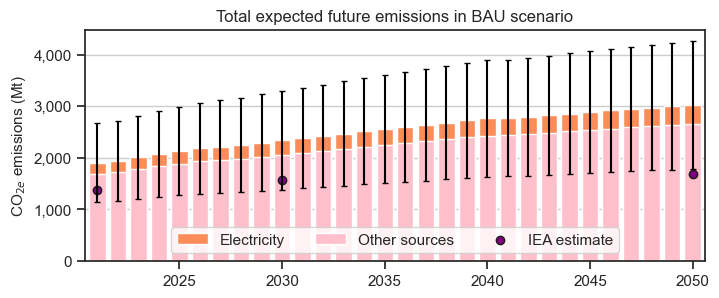

In [16]:
fig, ax = plt.subplots(1,1, figsize=[8,3])

df1 = filter_df(data_filt, ['Gas', 'Type'], [['CO2e_100a'], counting_types]).sum()
hist_years = [str(i) for i in range(2021, 2051)]

ax.bar(range(2021, 2051), df1[hist_years]/scale_factor, color=colors[0], label='Electricity')

df_elec = filter_df(data_with_elec, ['Gas', 'Type'], [['CO2e_100a'], ['Electricity']]).sum()

df2 = df1.copy()
df2[hist_years] = df2[hist_years]-df_elec[hist_years]
ax.bar(range(2021, 2051), df2[hist_years]/scale_factor, color='pink', label='Other sources')

iea_fx = [2021, 2030, 2050]
iea_fy = np.array((1.37, 1.30*1.2, 1.30*1.3))*1E3

ax.scatter(iea_fx, iea_fy,  color='purple',edgecolor='k', label='IEA estimate')

ax.set_ylabel('CO$_{2e}$ emissions (Mt)', fontsize=fontsize)
ax.set_xlim(2020.4,2050.6)
ax.grid(axis='y')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=[handles[1], handles[2], handles[0]], labels = [labels[1], labels[2], labels[0]], loc='lower center', ncol=3)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

hist_sigmas = [str(i)+'_sigma' for i in range(2021, 2051)]
ax.errorbar(range(2021, 2051), df1[hist_years]/scale_factor, df1[hist_sigmas]/scale_factor, linestyle='None', color='black', capsize=capsize)
ax.set_title('Total expected future emissions in BAU scenario')



In [ ]:
# Save output plot
fig.savefig(output_path+'Figure_S8.eps', format='eps', bbox_inches='tight',dpi=300)

# Save output plot
fig.savefig(output_path+'Figure_S8.png', format='png', bbox_inches='tight',dpi=300)

In [34]:
years = [str(i) for i in range(2021, 2051)]
df_save = pd.DataFrame()
df_save['Year'] = years
df_save['Total emissions'] = [f"{df1.loc[y]/1E6:.1f}±{df1.loc[y+'_sigma']/1E6:.1f}" for y in years]
df_save['Direct emissions'] = [f"{df2.loc[y]/1E6:.1f}±{df2.loc[y+'_sigma']/1E6:.1f}" for y in years]
df_save.to_csv('table_S6_update.csv')